# Lab 6_1 Variational Autoencoder

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 18.4MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 497kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.57MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.42MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
class VAE(nn.Module):
  def __init__(self,latent_dim=20):
    super(VAE,self).__init__()
    self.latent_dim=latent_dim
    #encoder
    self.encoder = nn.Sequential(
        nn.Linear(784,256),nn.ReLU(),
        nn.Linear(256,64),nn.ReLU(),
    )

    self.fc_mu =nn.Linear(64,latent_dim)
    self.fc_logvar =nn.Linear(64,latent_dim)

    #decoder
    self.decoder = nn.Sequential(
        nn.Linear(latent_dim,64),nn.ReLU(),
        nn.Linear(64,256),nn.ReLU(),
        nn.Linear(256,784),nn.Sigmoid()
    )

  # Define encode, reparameterize, decode, and forward as methods of the class
  def encode(self,x):
    h=self.encoder(x)
    mu=self.fc_mu(h)
    logvar=self.fc_logvar(h)
    return mu,logvar

  def reparameterize(self,mu,logvar):
    std=torch.exp(0.5*logvar)
    eps=torch.randn_like(std)
    return mu+eps*std

  def decode(self,z):
    return self.decoder(z)

  def forward(self,x):
    mu,logvar=self.encode(x)
    z=self.reparameterize(mu,logvar)
    return self.decode(z),mu,logvar

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 20
model = VAE(latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [5]:
def train(model, train_loader, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (x, _) in enumerate(train_loader):
            x = x.to(device)

            optimizer.zero_grad()
            x_recon, mu, log_var = model(x)

            # Reconstruction Loss (BCE)
            recon_loss = F.binary_cross_entropy(x_recon, x, reduction='sum')

            # KL Divergence Loss
            kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

            # Total Loss
            loss = recon_loss + kl_loss
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader.dataset):.4f}")

train(model, train_loader, epochs=10)

Epoch 1/10, Loss: 194.4460
Epoch 2/10, Loss: 143.0813
Epoch 3/10, Loss: 127.4614
Epoch 4/10, Loss: 120.4854
Epoch 5/10, Loss: 116.5340
Epoch 6/10, Loss: 113.9379
Epoch 7/10, Loss: 112.0584
Epoch 8/10, Loss: 110.6824
Epoch 9/10, Loss: 109.5643
Epoch 10/10, Loss: 108.7521


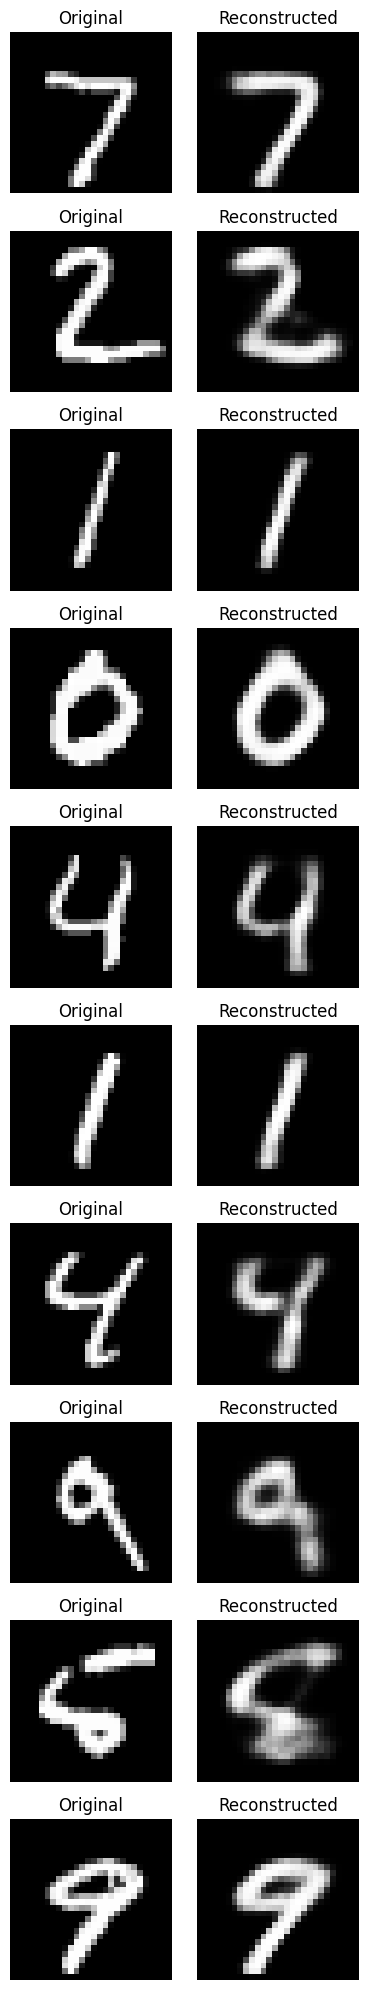

In [6]:
with torch.no_grad():
    dataiter = iter(test_loader)  # Get a batch of test data
    images, _ = next(dataiter)

    images = images.to(device)
    outputs, _, _ = model(images)  # Get the reconstructed images

    images = images.cpu().view(-1, 28, 28)  # Reshape to 28x28
    outputs = outputs.cpu().view(-1, 28, 28)  # Reshape to 28x28

    fig, axes = plt.subplots(10, 2, figsize=(4, 20))  # 10 pairs of images
    for i in range(10):
        # Original Image
        axes[i, 0].imshow(images[i], cmap='gray')
        axes[i, 0].axis('off')
        axes[i, 0].set_title("Original")

        # Reconstructed Image
        axes[i, 1].imshow(outputs[i], cmap='gray')
        axes[i, 1].axis('off')
        axes[i, 1].set_title("Reconstructed")

    plt.tight_layout()
    plt.show()
